# Spiking multicompartment PC network

## Abstract
Predictive coding is a promising theoretical framework for understanding the hierarchical sensory processing in the brain, yet how it is implemented with cortical spiking neurons is still unclear. While most existing works have taken a hand-wiring approach to creating microcircuits which match experimental results, recent work in applying the optimisation approach revealed that cortical connectivity might result from self-organisation given some fundamental computational principle, ie. energy efficiency. We thus investigated whether predictive coding properties in a multicompartment spiking neural network can result from energy optimisation. We found that only the model trained with an energy objective in addition to a task-relevant objective was able to reconstruct internal representations given top-down expectation signals alone. Neurons in the energy-optimised model also showed differential responses to expected vs unexpected stimuli, qualitatively similar to experimental evidence for predictive coding. These findings indicated that predictive-coding-like behaviour might be an emergent property of energy optimisation, providing a new perspective on how predictive coding could be achieved in the cortex.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.nn.parameter import Parameter
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms 
import numpy as np
from datetime import date
import os
import math
import shutil

import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

seed = 7
torch.manual_seed(seed)

# set seed
def set_seeds(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True
    np.random.seed(seed)


cuda


In [2]:
## Utils
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def save_checkpoint(state, is_best, prefix, filename='_rec2_bias_checkpoint.pth.tar'):
    print('saving at ', prefix + filename)
    torch.save(state, prefix + filename)
    if is_best:
        shutil.copyfile(prefix + filename, prefix + '_rec2_bias_model_best.pth.tar')


def model_result_dict_load(fn):
    """load tar file with saved model

    Args:
        fn (str): tar file name

    Returns:
        dict: dictornary containing saved results
    """
    with open(fn, 'rb') as f:
        dict = torch.load(f)
    return dict

def save_model(model_name,model):
    torch.save(model,"{}_model.pth".format(model_name))
    torch.save(model.state_dict(),"{}_state_dict.pth".format(model_name))

def load_model(model_name):
    model=torch.load(".\\{}_model.pth".format(model_name))
    return model

## Import dataset

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 200

traindata = torchvision.datasets.MNIST(root='./data', train=True,
                                       download=True, transform=transform)

testdata = torchvision.datasets.MNIST(root='./data', train=False,
                                      download=True, transform=transform)

# data loading
train_loader = torch.utils.data.DataLoader(traindata, batch_size=batch_size,
                                           shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(testdata, batch_size=batch_size,
                                          shuffle=False, num_workers=2)


## Surrogate gradient


In [4]:

b_j0 = 0.1  # neural threshold baseline

R_m = 3  # membrane resistance
gamma = .5  # gradient scale
lens = 0.5


def gaussian(x, mu=0., sigma=.5):
    return torch.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) / torch.sqrt(2 * torch.tensor(math.pi)) / sigma


class ActFun_adp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):  # input = membrane potential- threshold
        ctx.save_for_backward(input)
        return input.gt(0).float()  # is firing ???

    @staticmethod
    def backward(ctx, grad_output):  # approximate the gradients
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        # temp = abs(input) < lens
        scale = 6.0
        hight = .15
        # temp = torch.exp(-(input**2)/(2*lens**2))/torch.sqrt(2*torch.tensor(math.pi))/lens
        temp = gaussian(input, mu=0., sigma=lens) * (1. + hight) \
               - gaussian(input, mu=lens, sigma=scale * lens) * hight \
               - gaussian(input, mu=-lens, sigma=scale * lens) * hight
        # temp =  gaussian(input, mu=0., sigma=lens)
        return grad_input * temp.float() * gamma
        # return grad_input


act_fun_adp = ActFun_adp.apply

## Network layers

In [5]:
# layers
def shifted_sigmoid(currents):
    return (1 / (1 + torch.exp(-currents)) - 0.5)/2


class SnnLayer(nn.Module):
    def __init__(
            self,
            in_dim: int,
            hidden_dim: int,
            is_rec: bool,
            is_adapt: bool,
            one_to_one: bool,
            tau_m_init=15.,
            tau_adap_init=20,
            tau_a_init=15.,
            dt = 0.5,
            bias = True
    ):
        super(SnnLayer, self).__init__()

        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.is_rec = is_rec
        self.is_adapt = is_adapt
        self.one_to_one = one_to_one
        self.dt = dt

        if is_rec:
            self.rec_w = nn.Linear(hidden_dim, hidden_dim, bias=bias)
            # init weights
            if bias:
                nn.init.constant_(self.rec_w.bias, 0)
            nn.init.xavier_uniform_(self.rec_w.weight)

            p = torch.full(self.rec_w.weight.size(), fill_value=0.5).to(device)
            self.weight_mask = torch.bernoulli(p)

        else:
            self.fc_weights = nn.Linear(in_dim, hidden_dim, bias=bias)
            if bias:
                nn.init.constant_(self.fc_weights.bias, 0)
            nn.init.xavier_uniform_(self.fc_weights.weight)

        # define param for time constants
        self.tau_adp = nn.Parameter(torch.Tensor(hidden_dim))
        self.tau_m = nn.Parameter(torch.Tensor(hidden_dim))
        self.tau_a = nn.Parameter(torch.Tensor(hidden_dim))

        nn.init.normal_(self.tau_adp, tau_adap_init, .1)
        nn.init.normal_(self.tau_m, tau_m_init, .1)
        nn.init.normal_(self.tau_a, tau_a_init, .1)

        # self.tau_adp = nn.Parameter(torch.Tensor(1))
        # self.tau_m = nn.Parameter(torch.Tensor(1))
        # self.tau_a = nn.Parameter(torch.Tensor(1))

        # nn.init.constant_(self.tau_adp, tau_adap_init)
        # nn.init.constant_(self.tau_m, tau_m_init)
        # nn.init.constant_(self.tau_a, tau_a_init)

        # nn.init.normal_(self.tau_adp, 200., 20.)
        # nn.init.normal_(self.tau_m, 20., .5)

        self.sigmoid = nn.Sigmoid()

    def mem_update(self, ff, fb, soma, spike, a_curr, b, is_adapt, baseline_thre=b_j0, r_m=3):
        """
        mem update for each layer of neurons
        :param ff: feedforward signal
        :param fb: feedback signal to apical tuft
        :param soma: mem voltage potential at soma
        :param spike: spiking at last time step
        :param a_curr: apical tuft current at last t
        :param current: input current at last t
        :param b: adaptive threshold
        :return:
        """
        # alpha = self.sigmoid(self.tau_m)
        # rho = self.sigmoid(self.tau_adp)
        # eta = self.sigmoid(self.tau_a)
        alpha = torch.exp(-self.dt/self.tau_m)
        rho = torch.exp(-self.dt/self.tau_adp)
        eta = torch.exp(-self.dt/self.tau_a)

        if is_adapt:
            beta = 1.8
        else:
            beta = 0.

        b = rho * b + (1 - rho) * spike  # adaptive contribution
        new_thre = baseline_thre + beta * b  # udpated threshold
        
        current_new = ff 

        a_new = eta * a_curr + fb  # fb into apical tuft

        #print("mem update",current_decay , current_curr , ff, eta , a_curr , fb)
        
        soma_new = alpha * soma + shifted_sigmoid(a_new) + current_new - new_thre * spike
        # soma_new = alpha * soma + shifted_sigmoid(a_new) + rise * ff - new_thre * spike
        # soma_new = alpha * soma + 1/2 * (a_new) + ffs - new_thre * spike

        inputs_ = soma_new - new_thre

        spike = act_fun_adp(inputs_)  # act_fun : approximation firing function
        # mem = (1 - spike) * mem

        return soma_new, spike, a_new, new_thre, b

    def forward(self, ff, fb, soma_t, spk_t, a_curr_t, b_t):
        """
        forward function of a single layer. given previous neuron states and current input, update neuron states

        :param ff: ff signal (not counting rec)
        :param fb: fb top down signal
        :param soma_t: soma voltage
        :param a_curr_t: apical tuft voltage
        :return:
        """

        if self.is_rec:
            self.rec_w.weight.data = self.rec_w.weight.data * self.weight_mask
            # self.rec_w.weight.data = (self.rec_w.weight.data < 0).float() * self.rec_w.weight.data
            r_in = ff + self.rec_w(spk_t)
        else:
            if self.one_to_one:
                r_in = ff
            else:
                r_in = self.fc_weights(ff)

        soma_t1, spk_t1, a_curr_t1, _, b_t1 = self.mem_update(r_in, fb, soma_t, spk_t, a_curr_t, b_t, self.is_adapt)

        return soma_t1, spk_t1, a_curr_t1, b_t1


class SnnLayerRiseTime(nn.Module):
    def __init__(
            self,
            in_dim: int,
            hidden_dim: int,
            is_rec: bool,
            is_adapt: bool,
            one_to_one: bool,
            tau_m_init=15.,
            tau_curr_decay_init=10.,
            tau_adap_init=20,
            tau_a_init=15.,
            dt = 0.5,
            bias = True
    ):
        super(SnnLayerRiseTime, self).__init__()

        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.is_rec = is_rec
        self.is_adapt = is_adapt
        self.one_to_one = one_to_one
        self.dt = dt

        if is_rec:
            self.rec_w = nn.Linear(hidden_dim, hidden_dim, bias=bias)
            # init weights
            if bias:
                nn.init.constant_(self.rec_w.bias, 0)
            nn.init.xavier_uniform_(self.rec_w.weight)

            p = torch.full(self.rec_w.weight.size(), fill_value=0.5).to(device)
            self.weight_mask = torch.bernoulli(p)

        else:
            self.fc_weights = nn.Linear(in_dim, hidden_dim, bias=bias)
            if bias:
                nn.init.constant_(self.fc_weights.bias, 0)
            nn.init.xavier_uniform_(self.fc_weights.weight)

        # define param for time constants
        self.tau_adp = nn.Parameter(torch.Tensor(hidden_dim))
        self.tau_m = nn.Parameter(torch.Tensor(hidden_dim))
        self.tau_curr_decay = nn.Parameter(torch.Tensor(hidden_dim))
        self.tau_a = nn.Parameter(torch.Tensor(hidden_dim))

        nn.init.normal_(self.tau_adp, tau_adap_init, .1)
        nn.init.normal_(self.tau_m, tau_m_init, .1)
        nn.init.normal_(self.tau_curr_decay, tau_curr_decay_init, .1)
        nn.init.normal_(self.tau_a, tau_a_init, .1)

        # self.tau_adp = nn.Parameter(torch.Tensor(1))
        # self.tau_m = nn.Parameter(torch.Tensor(1))
        # self.tau_a = nn.Parameter(torch.Tensor(1))

        # nn.init.constant_(self.tau_adp, tau_adap_init)
        # nn.init.constant_(self.tau_m, tau_m_init)
        # nn.init.constant_(self.tau_a, tau_a_init)

        # nn.init.normal_(self.tau_adp, 200., 20.)
        # nn.init.normal_(self.tau_m, 20., .5)

        self.sigmoid = nn.Sigmoid()

    def mem_update(self, ff, fb, soma, spike, a_curr, current_curr, b, is_adapt, baseline_thre=b_j0, r_m=3):
        """
        mem update for each layer of neurons
        :param ff: feedforward signal
        :param fb: feedback signal to apical tuft
        :param soma: mem voltage potential at soma
        :param spike: spiking at last time step
        :param a_curr: apical tuft current at last t
        :param current: input current at last t
        :param b: adaptive threshold
        :return:
        """
        # alpha = self.sigmoid(self.tau_m)
        # rho = self.sigmoid(self.tau_adp)
        # eta = self.sigmoid(self.tau_a)
        alpha = torch.exp(-self.dt/self.tau_m)
        current_decay = torch.exp(-self.dt/self.tau_curr_decay)
        rho = torch.exp(-self.dt/self.tau_adp)
        eta = torch.exp(-self.dt/self.tau_a)

        if is_adapt:
            beta = 1.8
        else:
            beta = 0.
                
        b = rho * b + (1 - rho) * spike  # adaptive contribution
        new_thre = baseline_thre + beta * b  # udpated threshold
        
        current_new = current_decay * current_curr + ff

        a_new = eta * a_curr + fb  # fb into apical tuft

        #print("mem update",current_decay , current_curr , ff, eta , a_curr , fb)
        
        soma_new = alpha * soma + shifted_sigmoid(a_new) + current_new - new_thre * spike
        # soma_new = alpha * soma + shifted_sigmoid(a_new) + rise * ff - new_thre * spike
        # soma_new = alpha * soma + 1/2 * (a_new) + ffs - new_thre * spike

        inputs_ = soma_new - new_thre

        spike = act_fun_adp(inputs_)  # act_fun : approximation firing function
        # mem = (1 - spike) * mem

        return soma_new, spike, a_new, current_new, new_thre, b

    def forward(self, ff, fb, soma_t, spk_t, a_curr_t, current_curr_t, b_t):
        """
        forward function of a single layer. given previous neuron states and current input, update neuron states

        :param ff: ff signal (not counting rec)
        :param fb: fb top down signal
        :param soma_t: soma voltage
        :param a_curr_t: apical tuft voltage
        :return:
        """

        if self.is_rec:
            self.rec_w.weight.data = self.rec_w.weight.data * self.weight_mask
            # self.rec_w.weight.data = (self.rec_w.weight.data < 0).float() * self.rec_w.weight.data
            r_in = ff + self.rec_w(spk_t)
        else:
            if self.one_to_one:
                r_in = ff
            else:
                r_in = self.fc_weights(ff)

        soma_t1, spk_t1, a_curr_t1, current_curr_t1, _, b_t1 = self.mem_update(r_in, fb, soma_t, spk_t, a_curr_t, current_curr_t, b_t, self.is_adapt)

        return soma_t1, spk_t1, a_curr_t1, current_curr_t1, b_t1
        
class OutputLayer(nn.Module):
    def __init__(
            self,
            in_dim: int,
            out_dim: int,
            is_fc: bool,
            tau_fixed=None,
            bias = True,
            dt=0.5
    ):
        """
        output layer class
        :param is_fc: whether integrator is fc to r_out in rec or not
        """
        super(OutputLayer, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.is_fc = is_fc
        self.dt = dt

        if is_fc:
            self.fc = nn.Linear(in_dim, out_dim, bias=bias)
            if bias:
                nn.init.constant_(self.fc.bias, 0)
            nn.init.xavier_uniform_(self.fc.weight)

        # tau_m
        if tau_fixed is None:
            self.tau_m = nn.Parameter(torch.Tensor(out_dim))
            nn.init.constant_(self.tau_m, 5)
        else:
            self.tau_m = nn.Parameter(torch.Tensor(out_dim), requires_grad=False)
            nn.init.constant_(self.tau_m, tau_fixed)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x_t, mem_t):
        """
        integrator neuron without spikes
        """
        alpha = torch.exp(-self.dt/self.tau_m)
        # alpha = self.sigmoid(self.tau_m)

        if self.is_fc:
            x_t = self.fc(x_t)
        else:
            x_t = x_t.view(-1, 10, int(self.in_dim / 10)).mean(dim=2)  # sum up population spike

        # d_mem = -soma_t + x_t
        mem = (mem_t + x_t) * alpha
        # mem = alpha * soma_t + (1 - alpha) * x_t
        return mem



## Network class

In [ ]:
# 2 hidden layers
class Decorrelation(nn.Module):
    def __init__(self):
        super(Decorrelation, self).__init__()
        self.decorr_matrix_next = None
    
    def forward(self, input, decorr_matrix_prev_batch):
        n=1e-3
        diag = torch.diag_embed(torch.square(input)) # (batch_size,hidden_dim,hidden_dim)

        input = input.reshape(input.shape[0],input.shape[1],1) # (batch_size,hidden_dim,1)
        input = torch.matmul(decorr_matrix_prev_batch, input) # (batch_size,hidden_dim,1)

        mult = torch.matmul(input, torch.transpose(input,1,2)) # (batch_size,hidden_dim,hidden_dim)
        update = torch.mean(mult - diag, dim=0) # (hidden_dim,hidden_dim)
        self.decorr_matrix_next = decorr_matrix_prev_batch - n * torch.matmul(update, decorr_matrix_prev_batch) # (hidden_dim,hidden_dim)

        input = input.reshape(input.shape[0],input.shape[1]) # (batch_size,hidden_dim)
        return input
        
class SnnNetwork(nn.Module):
    def __init__(
            self,
            in_dim: int,
            hidden_dims: list,
            out_dim: int,
            is_adapt: bool,
            one_to_one: bool,
            dp_rate: float,
            is_rec: bool,
            rise_time: bool,
            bias = True
    ):
        super(SnnNetwork, self).__init__()

        self.in_dim = in_dim
        self.hidden_dims = hidden_dims
        self.out_dim = out_dim
        self.is_adapt = is_adapt
        self.one_to_one = one_to_one
        self.is_rec = is_rec
        self.rise_time = rise_time
        self.dp = nn.Dropout(dp_rate)

        if self.rise_time:
            self.layer1 = SnnLayerRiseTime(hidden_dims[0], hidden_dims[0], is_rec=is_rec, is_adapt=is_adapt,
                               one_to_one=one_to_one, bias=bias)
        else:
            self.layer1 = SnnLayer(hidden_dims[0], hidden_dims[0], is_rec=is_rec, is_adapt=is_adapt,
                               one_to_one=one_to_one, bias=bias)

        # r in to r out
        self.layer1to2 = nn.Linear(hidden_dims[0], hidden_dims[1], bias=bias)
        nn.init.xavier_uniform_(self.layer1to2.weight)

        # r out to r in
        self.layer2to1 = nn.Linear(hidden_dims[1], hidden_dims[0], bias=bias)
        nn.init.xavier_uniform_(self.layer2to1.weight)

        if self.rise_time:
            self.layer2 = SnnLayerRiseTime(hidden_dims[1], hidden_dims[1], is_rec=is_rec, is_adapt=is_adapt,
                               one_to_one=one_to_one, bias=bias)
        else:
            self.layer2 = SnnLayer(hidden_dims[1], hidden_dims[1], is_rec=is_rec, is_adapt=is_adapt,
                               one_to_one=one_to_one, bias=bias)

        self.output_layer = OutputLayer(hidden_dims[1], out_dim, is_fc=True, bias=bias)

        self.out2layer2 = nn.Linear(out_dim, hidden_dims[1], bias=bias)
        nn.init.xavier_uniform_(self.out2layer2.weight)

        if bias:
            nn.init.constant_(self.layer1to2.bias, 0)
            nn.init.constant_(self.layer2to1.bias, 0)
            nn.init.constant_(self.out2layer2.bias, 0)



        self.fr_layer2 = 0
        self.fr_layer1 = 0

        self.error1 = 0
        self.error2 = 0

    def forward(self, x_t, h):
        batch_dim, input_size = x_t.shape

        x_t = x_t.reshape(batch_dim, input_size).float()
        x_t = self.dp(x_t*0.5)
        # poisson
        # x_t = x_t.gt(0.7).float()

        soma_1, spk_1, a_curr_1, b_1 = self.layer1(ff=x_t, fb=self.layer2to1(h[5]), soma_t=h[0], spk_t=h[1],
                                                   a_curr_t=h[2], b_t=h[3])

        self.error1 = a_curr_1 - soma_1

        # use out mem signal as feedback
        soma_2, spk_2, a_curr_2, b_2 = self.layer2(ff=self.layer1to2(spk_1), fb=self.out2layer2(F.normalize(h[-1], dim=1)), soma_t=h[4],
                                                   spk_t=h[5], a_curr_t=h[6], b_t=h[7])

        self.error2 = a_curr_2 - soma_2

        self.fr_layer2 = self.fr_layer2 + spk_2.detach().cpu().numpy().mean()
        self.fr_layer1 = self.fr_layer1 + spk_1.detach().cpu().numpy().mean()

        # read out from r_out neurons
        mem_out = self.output_layer(spk_2, h[-1])

        h = (soma_1, spk_1, a_curr_1, b_1,
             soma_2, spk_2, a_curr_2, b_2,
             mem_out)

        log_softmax = F.log_softmax(mem_out, dim=1)

        return log_softmax, h

    def inference(self, x_t, h, T, bystep=None):
        """
        only called during inference
        :param x_t: input
        :param h: hidden states
        :param T: sequence length
        :param bystep: if true, then x_t is a sequence
        :return:
        """

        log_softmax_hist = []
        h_hist = []

        for t in range(T):

            if bystep is None:
                log_softmax, h = self.forward(x_t, h)
            else:
                log_softmax, h = self.forward(x_t[t], h)

            log_softmax_hist.append(log_softmax)
            h_hist.append(h)
            
        return log_softmax_hist, h_hist

    def inference_rise_time(self, x_t, h, T, bystep=None):
        """
        only called during inference
        :param x_t: input
        :param h: hidden states
        :param T: sequence length
        :param bystep: if true, then x_t is a sequence
        :return:
        """

        log_softmax_hist = []
        h_hist = []

        for t in range(T):

            if bystep is None:
                log_softmax, h = self.forward_rise_time(x_t, h)
            else:
                log_softmax, h = self.forward_rise_time(x_t[t], h)

            log_softmax_hist.append(log_softmax)
            h_hist.append(h)
            
        return log_softmax_hist, h_hist

    def clamped_generate(self, test_class, zeros, h_clamped, T, clamp_value=1, batch=False, noise=None):
        """
        generate representations with mem of read out clamped
        :param test_class: which class is clamped
        :param zeros: input containing zeros, absence of input
        :param h: hidden states
        :param T: sequence length
        :return:
        """

        log_softmax_hist = []
        h_hist = []

        for t in range(T):
            if not batch:
                h_clamped[-1][0] = -clamp_value
                h_clamped[-1][0, test_class] = clamp_value
            else:
                h_clamped[-1][:, :] = torch.full(h_clamped[-1].size(), -clamp_value).to(device)
                h_clamped[-1][:, test_class] = clamp_value

            if noise is not None:
                    h_clamped[-1][:] += noise

            # if t==0:
            #     print(h_clamped[-1])

            log_softmax, h_clamped = self.forward(zeros, h_clamped)

            log_softmax_hist.append(log_softmax)
            h_hist.append(h_clamped)

        return log_softmax_hist, h_hist

    def clamped_generate_rise_time(self, test_class, zeros, h_clamped, T, clamp_value=1, batch=False, noise=None):
        """
        generate representations with mem of read out clamped
        :param test_class: which class is clamped
        :param zeros: input containing zeros, absence of input
        :param h: hidden states
        :param T: sequence length
        :return:
        """

        log_softmax_hist = []
        h_hist = []

        for t in range(T):
            if not batch:
                h_clamped[-1][0] = -clamp_value
                h_clamped[-1][0, test_class] = clamp_value
            else:
                h_clamped[-1][:, :] = torch.full(h_clamped[-1].size(), -clamp_value).to(device)
                h_clamped[-1][:, test_class] = clamp_value

            if noise is not None:
                    h_clamped[-1][:] += noise

            # if t==0:
            #     print(h_clamped[-1])

            log_softmax, h_clamped = self.forward_rise_time(zeros, h_clamped)

            log_softmax_hist.append(log_softmax)
            h_hist.append(h_clamped)

        return log_softmax_hist, h_hist
        
    def init_hidden(self, bsz):
        weight = next(self.parameters()).data
        return (
            # r
            weight.new(bsz, self.hidden_dims[0]).uniform_(),
            weight.new(bsz, self.hidden_dims[0]).zero_(),
            weight.new(bsz, self.hidden_dims[0]).zero_(),
            weight.new(bsz, self.hidden_dims[0]).fill_(b_j0),
            # p
            weight.new(bsz, self.hidden_dims[1]).uniform_(),
            weight.new(bsz, self.hidden_dims[1]).zero_(),
            weight.new(bsz, self.hidden_dims[1]).zero_(),
            weight.new(bsz, self.hidden_dims[1]).fill_(b_j0),
            # layer out
            weight.new(bsz, self.out_dim).zero_(),
            # sum spike
            weight.new(bsz, self.out_dim).zero_(),
        )


# 3 hidden layers

class SnnNetwork3Layer(SnnNetwork):
    def __init__(
            self,
            in_dim: int,
            hidden_dims: list,
            out_dim: int,
            is_adapt: bool,
            one_to_one: bool,
            dp_rate: float,
            is_rec: bool,
            rise_time: bool,
            bias = True
    ):
        super().__init__(in_dim, hidden_dims, out_dim, is_adapt, one_to_one, dp_rate, is_rec, rise_time)

        # decorrelation
        self.decorr_layer_0 = Decorrelation()
        self.decorr_layer_1 = Decorrelation()
        self.decorr_layer_2 = Decorrelation()
        self.decorr_layer_3 = Decorrelation()
        self.decorr_layer_4 = Decorrelation()

        if self.rise_time:
            self.layer3 = SnnLayerRiseTime(hidden_dims[2], hidden_dims[2], is_rec=is_rec, is_adapt=is_adapt,
                               one_to_one=one_to_one, bias=bias)
        else:
            self.layer3 = SnnLayer(hidden_dims[2], hidden_dims[2], is_rec=is_rec, is_adapt=is_adapt,
                               one_to_one=one_to_one, bias=bias)
            
        self.layer2to3 = nn.Linear(hidden_dims[1], hidden_dims[2], bias=bias)
        nn.init.xavier_uniform_(self.layer2to3.weight)

        # r out to r in
        self.layer3to2 = nn.Linear(hidden_dims[2], hidden_dims[1], bias=bias)
        nn.init.xavier_uniform_(self.layer3to2.weight)

        self.output_layer = OutputLayer(hidden_dims[2], out_dim, is_fc=True)

        self.out2layer3 = nn.Linear(out_dim, hidden_dims[2], bias=bias)
        nn.init.xavier_uniform_(self.out2layer3.weight)

        self.fr_layer3 = 0

        self.error3 = 0

        self.input_fc = nn.Linear(in_dim, hidden_dims[0], bias=bias)
        nn.init.xavier_uniform_(self.input_fc.weight)

        if bias:
            nn.init.constant_(self.layer2to3.bias, 0)
            nn.init.constant_(self.layer3to2.bias, 0)
            nn.init.constant_(self.out2layer3.bias, 0)
            nn.init.constant_(self.input_fc.bias, 0)
            print('bias set to 0')

    def forward_rise_time(self, x_t, h):
        batch_dim, input_size = x_t.shape

        x_t = x_t.reshape(batch_dim, input_size).float()
        x_t = self.dp(x_t)
        # poisson
        # x_t = x_t.gt(0.7).float()
        x_t = self.input_fc(x_t)

        soma_1, spk_1, a_curr_1, current_curr_1, b_1 = self.layer1(ff=x_t, fb=self.layer2to1(h[6]), soma_t=h[0], spk_t=h[1],
                                                   a_curr_t=h[2], current_curr_t=h[3], b_t=h[4])

        self.error1 = a_curr_1 - soma_1

        # use out mem signal as feedback
        soma_2, spk_2, a_curr_2, current_curr_2, b_2 = self.layer2(ff=self.layer1to2(spk_1), fb=self.layer3to2(h[11]), soma_t=h[5],
                                                   spk_t=h[6], a_curr_t=h[7], current_curr_t=h[8], b_t=h[9])

        self.error2 = a_curr_2 - soma_2

        soma_3, spk_3, a_curr_3, current_curr_3, b_3 = self.layer3(ff=self.layer2to3(spk_2), fb=self.out2layer3(F.normalize(h[-1], dim=1)), soma_t=h[10],
                                                   spk_t=h[11], a_curr_t=h[12], current_curr_t=h[13], b_t=h[14])
        # soma_3, spk_3, a_curr_3, b_3 = self.layer3(ff=self.layer2to3(spk_2), fb=0, soma_t=h[8],
        #                                            spk_t=h[9], a_curr_t=h[10], b_t=h[11])

        self.error3 = a_curr_3 - soma_3

        self.fr_layer3 = self.fr_layer3 + spk_3.detach().cpu().numpy().mean()
        self.fr_layer2 = self.fr_layer2 + spk_2.detach().cpu().numpy().mean()
        self.fr_layer1 = self.fr_layer1 + spk_1.detach().cpu().numpy().mean()

        # read out from r_out neurons
        mem_out = self.output_layer(spk_3, h[-1])

        h = (soma_1, spk_1, a_curr_1, current_curr_1, b_1,
             soma_2, spk_2, a_curr_2, current_curr_2, b_2,
             soma_3, spk_3, a_curr_3, current_curr_3, b_3,
             mem_out)

        log_softmax = F.log_softmax(mem_out, dim=1)

        return log_softmax, h

    def forward(self, x_t, h):
        batch_dim, input_size = x_t.shape

        x_t = x_t.reshape(batch_dim, input_size).float()
        x_t = self.dp(x_t)
        # poisson
        # x_t = x_t.gt(0.7).float()
        x_t = self.input_fc(x_t)

        soma_1, spk_1, a_curr_1, b_1 = self.layer1(ff=x_t, fb=self.layer2to1(h[5]), soma_t=h[0], spk_t=h[1],
                                                   a_curr_t=h[2], b_t=h[3])

        self.error1 = a_curr_1 - soma_1

        # use out mem signal as feedback
        soma_2, spk_2, a_curr_2, b_2 = self.layer2(ff=self.layer1to2(spk_1), fb=self.layer3to2(h[9]), soma_t=h[4],
                                                   spk_t=h[5], a_curr_t=h[6], b_t=h[7])

        self.error2 = a_curr_2 - soma_2

        soma_3, spk_3, a_curr_3, b_3 = self.layer3(ff=self.layer2to3(spk_2), fb=self.out2layer3(F.normalize(h[-1], dim=1)), soma_t=h[8],
                                                   spk_t=h[9], a_curr_t=h[10], b_t=h[11])
        # soma_3, spk_3, a_curr_3, b_3 = self.layer3(ff=self.layer2to3(spk_2), fb=0, soma_t=h[8],
        #                                            spk_t=h[9], a_curr_t=h[10], b_t=h[11])

        self.error3 = a_curr_3 - soma_3

        self.fr_layer3 = self.fr_layer3 + spk_3.detach().cpu().numpy().mean()
        self.fr_layer2 = self.fr_layer2 + spk_2.detach().cpu().numpy().mean()
        self.fr_layer1 = self.fr_layer1 + spk_1.detach().cpu().numpy().mean()

        # read out from r_out neurons
        mem_out = self.output_layer(spk_3, h[-1])

        h = (soma_1, spk_1, a_curr_1, b_1,
             soma_2, spk_2, a_curr_2, b_2,
             soma_3, spk_3, a_curr_3, b_3,
             mem_out)

        log_softmax = F.log_softmax(mem_out, dim=1)

        return log_softmax, h
        
    def forward_decorrelation(self, x_t, h, decorr_matrix_0, decorr_matrix_1, decorr_matrix_2, decorr_matrix_3, decorr_matrix_4):
        batch_dim, input_size = x_t.shape

        x_t = x_t.reshape(batch_dim, input_size).float()
        x_t = self.dp(x_t)

        # poisson
        # x_t = x_t.gt(0.7).float()

        # decorrelate input
        x_t = self.decorr_layer_0(x_t, decorr_matrix_0)
        decorr_matrix_0 = self.decorr_layer_0.decorr_matrix_next.data.clone()
        x_t = self.input_fc(x_t)

        # decorrelate input to L1
        x_t = self.decorr_layer_1(x_t, decorr_matrix_1)
        decorr_matrix_1 = self.decorr_layer_1.decorr_matrix_next.data.clone()
        
        soma_1, spk_1, a_curr_1, b_1 = self.layer1(ff=x_t, fb=self.layer2to1(h[5]), soma_t=h[0], spk_t=h[1],
                                                   a_curr_t=h[2], b_t=h[3])
        self.error1 = a_curr_1 - soma_1

        # decorrelate input to L2
        spk_1 = self.decorr_layer_2(spk_1, decorr_matrix_2)
        decorr_matrix_2 = self.decorr_layer_2.decorr_matrix_next.data.clone()

        # use out mem signal as feedback
        soma_2, spk_2, a_curr_2, b_2 = self.layer2(ff=self.layer1to2(spk_1), fb=self.layer3to2(h[9]), soma_t=h[4],
                                                   spk_t=h[5], a_curr_t=h[6], b_t=h[7])
        self.error2 = a_curr_2 - soma_2

        # decorrelate input to L3
        spk_2 = self.decorr_layer_3(spk_2, decorr_matrix_3)
        decorr_matrix_3 = self.decorr_layer_3.decorr_matrix_next.data.clone()

        soma_3, spk_3, a_curr_3, b_3 = self.layer3(ff=self.layer2to3(spk_2), fb=self.out2layer3(F.normalize(h[-1], dim=1)), soma_t=h[8],
                                                   spk_t=h[9], a_curr_t=h[10], b_t=h[11])
        self.error3 = a_curr_3 - soma_3

        # decorrelate input to output layer
        spk_3 = self.decorr_layer_4(spk_3, decorr_matrix_4)
        decorr_matrix_4 = self.decorr_layer_4.decorr_matrix_next.data.clone()
        
        self.fr_layer3 = self.fr_layer3 + spk_3.detach().cpu().numpy().mean()
        self.fr_layer2 = self.fr_layer2 + spk_2.detach().cpu().numpy().mean()
        self.fr_layer1 = self.fr_layer1 + spk_1.detach().cpu().numpy().mean()

        # read out from r_out neurons
        mem_out = self.output_layer(spk_3, h[-1])

        h = (soma_1, spk_1, a_curr_1, b_1,
             soma_2, spk_2, a_curr_2, b_2,
             soma_3, spk_3, a_curr_3, b_3,
             mem_out)

        log_softmax = F.log_softmax(mem_out, dim=1)
        return log_softmax, h, decorr_matrix_0, decorr_matrix_1, decorr_matrix_2, decorr_matrix_3, decorr_matrix_4

    def inference_decorrelation(self, x_t, h, T, decorr_matrix_0, decorr_matrix_1, decorr_matrix_2, decorr_matrix_3, decorr_matrix_4, bystep=None):
        """
        only called during inference
        :param x_t: input
        :param h: hidden states
        :param T: sequence length
        :param bystep: if true, then x_t is a sequence
        :return:
        """

        log_softmax_hist = []
        h_hist = []

        for t in range(T):

            if bystep is None:
                log_softmax, h, decorr_matrix_0, decorr_matrix_1, decorr_matrix_2, decorr_matrix_3, decorr_matrix_4 = self.forward_decorrelation(x_t, h, decorr_matrix_0, decorr_matrix_1, decorr_matrix_2, decorr_matrix_3, decorr_matrix_4)
            else:
                log_softmax, h, decorr_matrix_0, decorr_matrix_1, decorr_matrix_2, decorr_matrix_3, decorr_matrix_4 = self.forward_decorrelation(x_t[t], h, decorr_matrix_0, decorr_matrix_1, decorr_matrix_2, decorr_matrix_3, decorr_matrix_4)

            log_softmax_hist.append(log_softmax)
            h_hist.append(h)
            
        return log_softmax_hist, h_hist

    def init_hidden_rise_time(self, bsz):
        weight = next(self.parameters()).data

        return (
            # l1
            weight.new(bsz, self.hidden_dims[0]).uniform_(),
            weight.new(bsz, self.hidden_dims[0]).zero_(),
            weight.new(bsz, self.hidden_dims[0]).zero_(),
            weight.new(bsz, self.hidden_dims[0]).zero_(),
            weight.new(bsz, self.hidden_dims[0]).fill_(b_j0),
            # l2
            weight.new(bsz, self.hidden_dims[1]).uniform_(),
            weight.new(bsz, self.hidden_dims[1]).zero_(),
            weight.new(bsz, self.hidden_dims[1]).zero_(),
            weight.new(bsz, self.hidden_dims[1]).zero_(),
            weight.new(bsz, self.hidden_dims[1]).fill_(b_j0),
            # l3
            weight.new(bsz, self.hidden_dims[2]).uniform_(),
            weight.new(bsz, self.hidden_dims[2]).zero_(),
            weight.new(bsz, self.hidden_dims[2]).zero_(),
            weight.new(bsz, self.hidden_dims[2]).zero_(),
            weight.new(bsz, self.hidden_dims[2]).fill_(b_j0),
            # layer out
            weight.new(bsz, self.out_dim).zero_(),
            # sum spike
            weight.new(bsz, self.out_dim).zero_(),
        )

    def init_hidden(self, bsz):
        weight = next(self.parameters()).data

        return (
            # l1
            weight.new(bsz, self.hidden_dims[0]).uniform_(),
            weight.new(bsz, self.hidden_dims[0]).zero_(),
            weight.new(bsz, self.hidden_dims[0]).zero_(),
            weight.new(bsz, self.hidden_dims[0]).fill_(b_j0),
            # l2
            weight.new(bsz, self.hidden_dims[1]).uniform_(),
            weight.new(bsz, self.hidden_dims[1]).zero_(),
            weight.new(bsz, self.hidden_dims[1]).zero_(),
            weight.new(bsz, self.hidden_dims[1]).fill_(b_j0),
            # l3
            weight.new(bsz, self.hidden_dims[2]).uniform_(),
            weight.new(bsz, self.hidden_dims[2]).zero_(),
            weight.new(bsz, self.hidden_dims[2]).zero_(),
            weight.new(bsz, self.hidden_dims[2]).fill_(b_j0),
            # layer out
            weight.new(bsz, self.out_dim).zero_(),
            # sum spike
            weight.new(bsz, self.out_dim).zero_(),
        )
        
    def init_hidden_allzero(self, bsz):
        weight = next(self.parameters()).data
        return (
            # l1
            weight.new(bsz, self.hidden_dims[0]).zero_(),
            weight.new(bsz, self.hidden_dims[0]).zero_(),
            weight.new(bsz, self.hidden_dims[0]).zero_(),
            weight.new(bsz, self.hidden_dims[0]).fill_(b_j0),
            # l2
            weight.new(bsz, self.hidden_dims[1]).zero_(),
            weight.new(bsz, self.hidden_dims[1]).zero_(),
            weight.new(bsz, self.hidden_dims[1]).zero_(),
            weight.new(bsz, self.hidden_dims[1]).fill_(b_j0),
            # l3
            weight.new(bsz, self.hidden_dims[2]).zero_(),
            weight.new(bsz, self.hidden_dims[2]).zero_(),
            weight.new(bsz, self.hidden_dims[2]).zero_(),
            weight.new(bsz, self.hidden_dims[2]).fill_(b_j0),
            # layer out
            weight.new(bsz, self.out_dim).zero_(),
            # sum spike
            weight.new(bsz, self.out_dim).zero_(),
        )

    def clamp_withnoise(self, test_class, zeros, h_clamped, T, noise, index, batch=False, clamp_value=0.5):
        """
        generate representations with mem of read out clamped
        :param test_class: which class is clamped
        :param zeros: input containing zeros, absence of input
        :param h: hidden states
        :param T: sequence length
        :param noise: noise values
        :param index: index in h where noise is added to
        :return:
        """

        log_softmax_hist = []
        h_hist = []

        for t in range(T):
            if not batch:
                h_clamped[-1][0] = -clamp_value
                h_clamped[-1][0, test_class] = clamp_value
            else:
                h_clamped[-1][:, :] = torch.full(h_clamped[-1].size(), -clamp_value).to(device)
                h_clamped[-1][:, test_class] = clamp_value

            if noise is not None:
                h_clamped[index][:, :] += noise * h_clamped[index][:, :]

            # if t==0:
            #     print(h_clamped[-1])

            log_softmax, h_clamped = self.forward(zeros, h_clamped)

            log_softmax_hist.append(log_softmax)
            h_hist.append(h_clamped)

        return log_softmax_hist, h_hist



## FTTP

In [7]:
alpha = .2
beta = .5
rho = 0.


# %%
def get_stats_named_params(model):
    named_params = {}
    for name, param in model.named_parameters():
        sm, lm, dm = param.detach().clone(), 0.0 * param.detach().clone(), 0.0 * param.detach().clone()
        named_params[name] = (param, sm, lm, dm)
    return named_params


def post_optimizer_updates(named_params):
    for name in named_params:
        param, sm, lm, dm = named_params[name]
        lm.data.add_(-alpha * (param - sm))
        sm.data.mul_((1.0 - beta))
        sm.data.add_(beta * param - (beta / alpha) * lm)


def get_regularizer_named_params(named_params, _lambda=1.0):
    regularization = torch.zeros([], device=device)
    for name in named_params:
        param, sm, lm, dm = named_params[name]
        regularization += (rho - 1.) * torch.sum(param * lm)
        r_p = _lambda * 0.5 * alpha * torch.sum(torch.square(param - sm))
        regularization += r_p
        # print(name,r_p)
    return regularization


def reset_named_params(named_params):
    for name in named_params:
        param, sm, lm, dm = named_params[name]
        param.data.copy_(sm.data)


def train_fptt(epoch, batch_size, log_interval,
               train_loader, model, named_params,
               time_steps, k_updates, omega, optimizer,
               clf_alpha, energy_alpha, spike_alpha, clip, lr, rise_time):
    train_loss = 0
    total_clf_loss = 0
    total_regularizaton_loss = 0
    total_energy_loss = 0
    total_spike_loss = 0
    correct = 0
    model.train()
    spk3,memout=[],[]
    # for each batch
    for batch_idx, (data, target) in enumerate(train_loader):

        # to device and reshape
        data, target = data.to(device), target.to(device)
        data = data.view(-1, model.in_dim)

        B = target.size()[0]

        for p in range(time_steps):
            
            if p == 0:
                if rise_time:
                    h = model.init_hidden_rise_time(data.size(0))
                else:
                    h = model.init_hidden(data.size(0))
            elif p % omega == 0:
                h = tuple(v.detach() for v in h)

            if rise_time:
                o, h = model.forward_rise_time(data, h)
            else:
                o, h = model.forward(data, h)
            #print("\n\nbatch",batch_idx)
            #print("\np",p)
            #print("\nh1",h[1],"\nh6",h[6],"\nh11",h[11])
            #print("\nmemout",h[-1])
            #spk3.append(h[11])
            #memout.append(h[-1])

            # wandb.log({
            #         'rec layer adap threshold': h[5].detach().cpu().numpy(),
            #         'rec layer mem potential': h[3].detach().cpu().numpy()
            #     })

            # get prediction
            if p == (time_steps - 1):
                pred = o.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).cpu().sum()

            if p % omega == 0 and p > 0:
                optimizer.zero_grad()

                # classification loss
                #print("k updates",k_updates,F.nll_loss(o, target),"o",o,o.shape,"target",target,target.shape)
                clf_loss = (p + 1) / k_updates * F.nll_loss(o, target)
                # clf_loss = snr*F.cross_entropy(output, target,reduction='none')
                # clf_loss = torch.mean(clf_loss)

                # regularizer loss
                regularizer = get_regularizer_named_params(named_params, _lambda=1.0)

                # mem potential loss take l1 norm / num of neurons /batch size
                if len(model.hidden_dims) == 2:
                    energy = (torch.sum(model.error1 ** 2) + torch.sum(model.error2 ** 2)) / B / sum(model.hidden_dims)
                    spike_loss = (torch.sum(h[1]) + torch.sum(h[5])) / B / sum(model.hidden_dims)
                elif len(model.hidden_dims) == 3:
                    # energy = (torch.sum(model.error1 ** 2) + torch.sum(model.error2 ** 2) + torch.sum(model.error3 ** 2)) / B / sum(model.hidden_dims)
                    energy = (torch.sum(torch.abs(model.error1)) + torch.sum(torch.abs(model.error2)) + torch.sum(torch.abs(model.error3))) / B / sum(model.hidden_dims)
                    spike_loss = (torch.sum(h[1]) + torch.sum(h[5]) + torch.sum(h[9])) / B / sum(model.hidden_dims)


                # overall loss
                #print("Loss", clf_loss, regularizer, energy, spike_loss)
                loss = clf_alpha * clf_loss + regularizer + energy_alpha * energy + spike_alpha * spike_loss

                loss.backward()

                if clip > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

                optimizer.step()
                post_optimizer_updates(named_params)

                train_loss += loss.item()
                total_clf_loss += clf_loss.item()
                total_regularizaton_loss += regularizer  # .item()
                total_energy_loss += energy.item()
                total_spike_loss += spike_loss.item()


                model.error1 = 0
                model.error2 = 0
                if len(model.hidden_dims) == 3:
                    model.error3 = 0


        if batch_idx > 0 and batch_idx % log_interval == (log_interval - 1):
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tenerg: {:.6f}\tlr: {:.6f}\ttrain acc:{:.4f}\tLoss: {:.6f}\
                \tClf: {:.6f}\tReg: {:.6f}\tFr_p: {:.6f}\tFr_r: {:.6f}'.format(
                epoch, batch_idx * batch_size, len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), total_energy_loss / log_interval,
                      lr, 100 * correct / (log_interval * B),
                       train_loss / log_interval,
                       total_clf_loss / log_interval, total_regularizaton_loss / log_interval,
                       model.fr_layer2 / time_steps / log_interval,
                       model.fr_layer1 / time_steps / log_interval))


            train_loss = 0
            total_clf_loss = 0
            total_regularizaton_loss = 0
            total_energy_loss = 0
            total_spike_loss = 0
            correct = 0
            # model.network.fr = 0
            model.fr_layer2 = 0
            model.fr_layer1 = 0
            if len(model.hidden_dims) == 3:
                model.fr_layer3 = 0


def train_fptt_decorr(epoch, batch_size, log_interval,
               train_loader, model, named_params,
               time_steps, k_updates, omega, optimizer,
               clf_alpha, energy_alpha, spike_alpha, clip, lr, decorr_matrix_0, decorr_matrix_1, decorr_matrix_2, decorr_matrix_3, decorr_matrix_4):
    train_loss = 0
    total_clf_loss = 0
    total_regularizaton_loss = 0
    total_energy_loss = 0
    total_spike_loss = 0
    correct = 0
    model.train()

    # for each batch
    for batch_idx, (data, target) in enumerate(train_loader):

        # to device and reshape
        data, target = data.to(device), target.to(device)
        data = data.view(-1, model.in_dim)

        B = target.size()[0]

        for p in range(time_steps):

            if p == 0:
                h = model.init_hidden(data.size(0))
            elif p % omega == 0:
                h = tuple(v.detach() for v in h)

            o, h, decorr_matrix_0, decorr_matrix_1, decorr_matrix_2, decorr_matrix_3, decorr_matrix_4 = model.forward_decorrelation(data, h, decorr_matrix_0, decorr_matrix_1, decorr_matrix_2, decorr_matrix_3, decorr_matrix_4)
            # wandb.log({
            #         'rec layer adap threshold': h[5].detach().cpu().numpy(),
            #         'rec layer mem potential': h[3].detach().cpu().numpy()
            #     })

            # get prediction
            if p == (time_steps - 1):
                pred = o.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).cpu().sum()

            if p % omega == 0 and p > 0:
                optimizer.zero_grad()

                # classification loss
                clf_loss = (p + 1) / k_updates * F.nll_loss(o, target)
                # clf_loss = snr*F.cross_entropy(output, target,reduction='none')
                # clf_loss = torch.mean(clf_loss)

                # regularizer loss
                regularizer = get_regularizer_named_params(named_params, _lambda=1.0)

                # mem potential loss take l1 norm / num of neurons /batch size
                if len(model.hidden_dims) == 2:
                    energy = (torch.sum(model.error1 ** 2) + torch.sum(model.error2 ** 2)) / B / sum(model.hidden_dims)
                    spike_loss = (torch.sum(h[1]) + torch.sum(h[5])) / B / sum(model.hidden_dims)
                elif len(model.hidden_dims) == 3:
                    # energy = (torch.sum(model.error1 ** 2) + torch.sum(model.error2 ** 2) + torch.sum(model.error3 ** 2)) / B / sum(model.hidden_dims)
                    energy = (torch.sum(torch.abs(model.error1)) + torch.sum(torch.abs(model.error2)) + torch.sum(torch.abs(model.error3))) / B / sum(model.hidden_dims)
                    spike_loss = (torch.sum(h[1]) + torch.sum(h[5]) + torch.sum(h[9])) / B / sum(model.hidden_dims)


                # overall loss
                loss = clf_alpha * clf_loss + regularizer + energy_alpha * energy + spike_alpha * spike_loss

                loss.backward(retain_graph=True)

                if clip > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

                optimizer.step()
                post_optimizer_updates(named_params)

                train_loss += loss.item()
                total_clf_loss += clf_loss.item()
                total_regularizaton_loss += regularizer  # .item()
                total_energy_loss += energy.item()
                total_spike_loss += spike_loss.item()


                model.error1 = 0
                model.error2 = 0
                if len(model.hidden_dims) == 3:
                    model.error3 = 0


        if batch_idx > 0 and batch_idx % log_interval == (log_interval - 1):
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tenerg: {:.6f}\tlr: {:.6f}\ttrain acc:{:.4f}\tLoss: {:.6f}\
                \tClf: {:.6f}\tReg: {:.6f}\tFr_p: {:.6f}\tFr_r: {:.6f}'.format(
                epoch, batch_idx * batch_size, len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), total_energy_loss / log_interval,
                      lr, 100 * correct / (log_interval * B),
                       train_loss / log_interval,
                       total_clf_loss / log_interval, total_regularizaton_loss / log_interval,
                       model.fr_layer2 / time_steps / log_interval,
                       model.fr_layer1 / time_steps / log_interval))


            train_loss = 0
            total_clf_loss = 0
            total_regularizaton_loss = 0
            total_energy_loss = 0
            total_spike_loss = 0
            correct = 0
            # model.network.fr = 0
            model.fr_layer2 = 0
            model.fr_layer1 = 0
            if len(model.hidden_dims) == 3:
                model.fr_layer3 = 0

    return decorr_matrix_0, decorr_matrix_1, decorr_matrix_2, decorr_matrix_3, decorr_matrix_4




## Test function

In [8]:
# test function
def test(model, test_loader, time_steps):
    model.eval()
    test_loss = 0
    correct = 0
    test_energy = 0
    
    # for data, target in test_loader:
    for i, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.view(-1, model.in_dim)

        with torch.no_grad():
            model.eval()
            hidden = model.init_hidden(data.size(0))
            
            log_softmax_outputs, hidden = model.inference(data, hidden, time_steps)

            test_loss += F.nll_loss(log_softmax_outputs[-1], target, reduction='sum').data.item()

            pred = log_softmax_outputs[-1].data.max(1, keepdim=True)[1]

            test_energy += (torch.sum(torch.abs(model.error1)) + torch.sum(torch.abs(model.error2)) + torch.sum(torch.abs(model.error3))) / target.size()[0] / sum(model.hidden_dims)

        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        torch.cuda.empty_cache()

    # wandb.log({'spike sequence': plot_spiking_sequence(hidden, target)})

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)
    test_energy /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        test_acc))

    return test_loss, 100. * correct / len(test_loader.dataset), test_energy

# test function
def test_with_added_noise(model, test_loader, time_steps, noise_mean, noise_std):
    model.eval()
    test_loss = 0
    correct = 0
    test_energy = 0
    
    # for data, target in test_loader:
    for i, (data, target) in enumerate(test_loader):
        data + torch.randn(data.size()) * noise_std + noise_mean
        data, target = data.to(device), target.to(device)
        data = data.view(-1, model.in_dim)

        with torch.no_grad():
            model.eval()
            hidden = model.init_hidden(data.size(0))
            
            log_softmax_outputs, hidden = model.inference(data, hidden, time_steps)

            test_loss += F.nll_loss(log_softmax_outputs[-1], target, reduction='sum').data.item()

            pred = log_softmax_outputs[-1].data.max(1, keepdim=True)[1]

            test_energy += (torch.sum(torch.abs(model.error1)) + torch.sum(torch.abs(model.error2)) + torch.sum(torch.abs(model.error3))) / target.size()[0] / sum(model.hidden_dims)

        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        torch.cuda.empty_cache()

    # wandb.log({'spike sequence': plot_spiking_sequence(hidden, target)})

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)
    test_energy /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        test_acc))

    return test_loss, 100. * correct / len(test_loader.dataset), test_energy

def test_rise_time(model, test_loader, time_steps):
    model.eval()
    test_loss = 0
    correct = 0
    test_energy = 0
    
    # for data, target in test_loader:
    for i, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.view(-1, model.in_dim)

        with torch.no_grad():
            model.eval()
            hidden = model.init_hidden_rise_time(data.size(0))
            
            log_softmax_outputs, hidden = model.inference_rise_time(data, hidden, time_steps)

            test_loss += F.nll_loss(log_softmax_outputs[-1], target, reduction='sum').data.item()

            pred = log_softmax_outputs[-1].data.max(1, keepdim=True)[1]

            test_energy += (torch.sum(torch.abs(model.error1)) + torch.sum(torch.abs(model.error2)) + torch.sum(torch.abs(model.error3))) / target.size()[0] / sum(model.hidden_dims)

        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        torch.cuda.empty_cache()

    # wandb.log({'spike sequence': plot_spiking_sequence(hidden, target)})

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)
    test_energy /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        test_acc))

    return test_loss, 100. * correct / len(test_loader.dataset), test_energy

# test function
def test_decorrelation(model, test_loader, time_steps, decorr_matrix_0, decorr_matrix_1, decorr_matrix_2, decorr_matrix_3, decorr_matrix_4):
    model.eval()
    test_loss = 0
    correct = 0
    
    # for data, target in test_loader:
    for i, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.view(-1, model.in_dim)

        with torch.no_grad():
            model.eval()
            hidden = model.init_hidden(data.size(0))
            
            log_softmax_outputs, hidden = model.inference_decorrelation(data, hidden, time_steps, decorr_matrix_0, decorr_matrix_1, decorr_matrix_2, decorr_matrix_3, decorr_matrix_4)

            test_loss += F.nll_loss(log_softmax_outputs[-1], target, reduction='sum').data.item()

            pred = log_softmax_outputs[-1].data.max(1, keepdim=True)[1]

        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        torch.cuda.empty_cache()

    # wandb.log({'spike sequence': plot_spiking_sequence(hidden, target)})

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        test_acc))

    return test_loss, 100. * correct / len(test_loader.dataset)




## Defining the network

In [9]:
# network parameters
adap_neuron = True  # whether use adaptive neuron or not
clf_alpha = 1

model_type = "energy"
if model_type == "control":
    energy_alpha = 0
else:
    energy_alpha = 0.05
    
spike_alpha = 0.  # energy loss on spikes
num_readout = 10
onetoone = True
lr = 1e-3
alg = 'fptt'
dp = 0.4
is_rec = False

# training parameters
T = 50
K = 10  # k_updates is num updates per sequence
omega = int(T / K)  # update frequency
clip = 1.
log_interval = 20
epochs = 15


In [10]:
# set input and t param
IN_dim = 784
hidden_dim = [600, 500, 500]
n_classes = 10
rise_time=False

# define network
model = SnnNetwork3Layer(IN_dim, hidden_dim, n_classes, is_adapt=adap_neuron,
                         one_to_one=onetoone, dp_rate=dp, is_rec=is_rec, rise_time=rise_time)
model.to(device)
print(model)

# define new loss and optimiser
total_params = count_parameters(model)
print('total param count %i' % total_params)

# define optimiser
optimizer = optim.Adamax(model.parameters(), lr=lr, weight_decay=0.0001)
# reduce the learning after 20 epochs by a factor of 10
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)


bias set to 0
SnnNetwork3Layer(
  (dp): Dropout(p=0.4, inplace=False)
  (layer1): SnnLayer(
    (fc_weights): Linear(in_features=600, out_features=600, bias=True)
    (sigmoid): Sigmoid()
  )
  (layer1to2): Linear(in_features=600, out_features=500, bias=True)
  (layer2to1): Linear(in_features=500, out_features=600, bias=True)
  (layer2): SnnLayer(
    (fc_weights): Linear(in_features=500, out_features=500, bias=True)
    (sigmoid): Sigmoid()
  )
  (output_layer): OutputLayer(
    (fc): Linear(in_features=500, out_features=10, bias=True)
    (sigmoid): Sigmoid()
  )
  (out2layer2): Linear(in_features=10, out_features=500, bias=True)
  (decorr_layer_0): Decorrelation()
  (decorr_layer_1): Decorrelation()
  (decorr_layer_2): Decorrelation()
  (decorr_layer_3): Decorrelation()
  (decorr_layer_4): Decorrelation()
  (layer3): SnnLayer(
    (fc_weights): Linear(in_features=500, out_features=500, bias=True)
    (sigmoid): Sigmoid()
  )
  (layer2to3): Linear(in_features=500, out_features=500, b

## Load models

In [ ]:
# Checkpoint to load for 97% accuracy
load_epoch_control = 7
load_epoch_energy = 9 

control_model = torch.load('results/base_control/{}_model.pth'.format(load_epoch_control))
energy_model = torch.load('results/base_energy/{}_model.pth'.format(load_epoch_energy))

/tmp/ipykernel_2877911/2279865490.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  control_model = torch.load('/home/p318679/Documents/SNN_PC_Multicomp/results/base_contr

# Figures 5 c-f with match / mismatch between consecutive inputs

In [16]:
def clamped_generate_surprise(model, test_class, input, h_clamped, T, clamp_value=1, clamp_bool=False, batch=False, noise=None):
        """
        generate representations with mem of read out clamped
        :param test_class: which class is clamped
        :param input: input containing input, absence of input
        :param h: hidden states
        :param T: sequence length
        :return:
        """

        log_softmax_hist = []
        h_hist = []

        for t in range(T):
            if clamp_bool:
                if not batch:
                    h_clamped[-1][0] = -clamp_value
                    h_clamped[-1][0, test_class] = clamp_value
                else:
                    h_clamped[-1][:, :] = torch.full(h_clamped[-1].size(), -clamp_value).to(device)
                    h_clamped[-1][:, test_class] = clamp_value

            if noise is not None:
                    h_clamped[-1][:] += noise

            # if t==0:
            #     print(h_clamped[-1])

            log_softmax, h_clamped = model.forward(input, h_clamped)

            log_softmax_hist.append(log_softmax)
            h_hist.append(h_clamped)

        return log_softmax_hist, h_hist, h_clamped

In [17]:
def get_states(hiddens_all_: list, idx: int, hidden_dim_: int, batch_size, T=20, num_samples=10000):
    """
    get a particular internal state depending on index passed to hidden
    :param hidden_dim_: the size of a state, eg. num of r or p neurons
    :param T: total time steps
    :param hiddens_all_: list containing hidden states of all batch and time steps during inference
    :param idx: which index in h is taken out
    :return: np array containing desired states
    """
    all_states = []
    for batch_idx in range(len(hiddens_all_)):  # iterate over batch
        batch_ = []
        for t in range(T):
            seq_ = []
            for b in range(batch_size):
                seq_.append(hiddens_all_[batch_idx][t][idx][b].detach().cpu().numpy())
            seq_ = np.stack(seq_)
            batch_.append(seq_)
        batch_ = np.stack(batch_)
        all_states.append(batch_)

    all_states = np.stack(all_states)

    return all_states.transpose(0, 2, 1, 3).reshape(num_samples, T, hidden_dim_)

In [36]:
def get_results(model,element,keep_time,seed,clamp_value):
    set_seeds(seed)

    # clamped generation of internal representations 
    no_input = torch.zeros((1, IN_dim)).to(device)

    clamp_T = T 

    # Match between consecutive inputs (they belong to the same class)
    result_id = 0
    if keep_time:
        l1_clamp_expected = np.zeros((10000, int(T/2), hidden_dim[0]))
        l2_clamp_expected = np.zeros((10000, int(T/2), hidden_dim[1]))
        l3_clamp_expected = np.zeros((10000, int(T/2), hidden_dim[2]))
    else:
        l1_clamp_expected = np.zeros((10000, hidden_dim[0]))
        l2_clamp_expected = np.zeros((10000, hidden_dim[1]))
        l3_clamp_expected = np.zeros((10000, hidden_dim[2]))

    test_loader2 = torch.utils.data.DataLoader(testdata, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
    for batch_id, (x,y) in enumerate(test_loader2):

        for input_class in range(10):
            n_images = (y==input_class).sum()
            for image_idx in range(0,10,2):
                image1 = x[y==input_class][image_idx][0].reshape(1,784).to(device)
                image2 = x[y==input_class][image_idx+1][0].reshape(1,784).to(device)
                clamp_class = input_class

                with torch.no_grad():
                    model.eval()

                    hidden_i = model.init_hidden(1)
                    # no input for T/4 timesteps before stimulus onset
                    _, _, hidden_i = clamped_generate_surprise(model, clamp_class, no_input, hidden_i, int(clamp_T / 4), clamp_value=clamp_value, clamp_bool=False)
                    # clamped stimulus for T/2 timesteps
                    _, h_hist1, hidden_i = clamped_generate_surprise(model, clamp_class, image1, hidden_i, int(clamp_T / 2), clamp_value=clamp_value, clamp_bool=False)
                    # no input for T/4 timesteps after stimulus 
                    _, _, hidden_i = clamped_generate_surprise(model, clamp_class, no_input, hidden_i, int(clamp_T / 4), clamp_value=clamp_value, clamp_bool=False)
                    
                    # no input for T/4 timesteps before stimulus onset
                    _, _, hidden_i = clamped_generate_surprise(model, clamp_class, no_input, hidden_i, int(clamp_T / 4), clamp_value=clamp_value, clamp_bool=False)
                    # clamped stimulus for T/2 timesteps
                    _, h_hist2, hidden_i = clamped_generate_surprise(model, clamp_class, image2, hidden_i, int(clamp_T / 2), clamp_value=clamp_value, clamp_bool=False)
                    # no input for T/4 timesteps after stimulus 
                    _, _, hidden_i = clamped_generate_surprise(model, clamp_class, no_input, hidden_i, int(clamp_T / 4), clamp_value=clamp_value, clamp_bool=False)

                    if element == 'apical':
                        #l1_E = get_states([h_hist2], 2, hidden_dim[0], 1, int(clamp_T/2), num_samples=1)
                        l2_E = get_states([h_hist2], 6, hidden_dim[1], 1, int(clamp_T/2), num_samples=1)
                        #l3_E = get_states([h_hist2], 10, hidden_dim[2], 1, int(clamp_T/2), num_samples=1)
                    elif element == 'soma':
                        #l1_E = get_states([h_hist2], 0, hidden_dim[0], 1, int(clamp_T/2), num_samples=1)
                        l2_E = get_states([h_hist2], 4, hidden_dim[1], 1, int(clamp_T/2), num_samples=1)
                        #l3_E = get_states([h_hist2], 8, hidden_dim[2], 1, int(clamp_T/2), num_samples=1)
                    elif element == 'spikes':
                        l1_E = get_states([h_hist2], 1, hidden_dim[0], 1, int(clamp_T/2), num_samples=1)
                        l2_E = get_states([h_hist2], 5, hidden_dim[1], 1, int(clamp_T/2), num_samples=1)
                        l3_E = get_states([h_hist2], 9, hidden_dim[2], 1, int(clamp_T/2), num_samples=1)

                    if keep_time:
                        l2_clamp_expected[result_id] += np.squeeze(l2_E)
                        if element == 'spikes':
                            l1_clamp_expected[result_id] += np.squeeze(l1_E)
                            l3_clamp_expected[result_id] += np.squeeze(l3_E)
                    else:
                        l2_clamp_expected[result_id] += np.squeeze(l2_E.mean(axis=1))
                        if element == 'spikes':
                            l1_clamp_expected[result_id] += np.squeeze(l1_E.mean(axis=1))
                            l3_clamp_expected[result_id] += np.squeeze(l3_E.mean(axis=1))

                    result_id += 1
                    if result_id > 9999:
                        break
                torch.cuda.empty_cache()

    # Mismatch between consecutive inputs (they belong to different classes)
    result_id = 0
    set_seeds(seed)
    if keep_time:
        l1_clamp_surprise = np.zeros((10000, int(T/2), hidden_dim[0]))
        l2_clamp_surprise = np.zeros((10000, int(T/2), hidden_dim[1]))
        l3_clamp_surprise = np.zeros((10000, int(T/2), hidden_dim[2]))
    else:
        l1_clamp_surprise = np.zeros((10000, hidden_dim[0]))
        l2_clamp_surprise = np.zeros((10000, hidden_dim[1]))
        l3_clamp_surprise = np.zeros((10000, hidden_dim[2]))

    for batch_id, (x,y) in enumerate(test_loader2):
        for input_class in range(10):
            n_images = (y==input_class).sum()
            for image_idx in range(0,10,2):
                image1 = x[y==input_class][image_idx][0].reshape(1,784).to(device)
                surprise_class = np.random.choice(np.array(list(set(range(10))-set([input_class]))))
                image2 = x[y==surprise_class][image_idx][0].reshape(1,784).to(device)
                
                with torch.no_grad():
                    model.eval()

                    clamp_class = input_class
                    hidden_i = model.init_hidden(1)
                    # no input for T/4 timesteps before stimulus onset
                    _, _, hidden_i = clamped_generate_surprise(model, clamp_class, no_input, hidden_i, int(clamp_T / 4), clamp_value=clamp_value, clamp_bool=False)
                    # clamped stimulus for T/2 timesteps
                    _, h_hist1, hidden_i = clamped_generate_surprise(model, clamp_class, image1, hidden_i, int(clamp_T / 2), clamp_value=clamp_value, clamp_bool=False)
                    # no input for T/4 timesteps after stimulus 
                    _, _, hidden_i = clamped_generate_surprise(model, clamp_class, no_input, hidden_i, int(clamp_T / 4), clamp_value=clamp_value, clamp_bool=False)
                    
                    clamp_class = surprise_class
                    # no input for T/4 timesteps before stimulus onset
                    _, _, hidden_i = clamped_generate_surprise(model, clamp_class, no_input, hidden_i, int(clamp_T / 4), clamp_value=clamp_value, clamp_bool=False)
                    # clamped stimulus for T/2 timesteps
                    _, h_hist2, hidden_i = clamped_generate_surprise(model, clamp_class, image2, hidden_i, int(clamp_T / 2), clamp_value=clamp_value, clamp_bool=False)
                    # no input for T/4 timesteps after stimulus 
                    _, _, hidden_i = clamped_generate_surprise(model, clamp_class, no_input, hidden_i, int(clamp_T / 4), clamp_value=clamp_value, clamp_bool=False)

                    #
                    if element == 'apical':
                        #l1_E = get_states([h_hist2], 2, hidden_dim[0], 1, int(clamp_T/2), num_samples=1)
                        l2_E = get_states([h_hist2], 6, hidden_dim[1], 1, int(clamp_T/2), num_samples=1)
                        #l3_E = get_states([h_hist2], 10, hidden_dim[2], 1, int(clamp_T/2), num_samples=1)
                    elif element == 'soma':
                        #l1_E = get_states([h_hist2], 0, hidden_dim[0], 1, int(clamp_T/2), num_samples=1)
                        l2_E = get_states([h_hist2], 4, hidden_dim[1], 1, int(clamp_T/2), num_samples=1)
                        #l3_E = get_states([h_hist2], 8, hidden_dim[2], 1, int(clamp_T/2), num_samples=1)
                    elif element == 'spikes':
                        l1_E = get_states([h_hist2], 1, hidden_dim[0], 1, int(clamp_T/2), num_samples=1)
                        l2_E = get_states([h_hist2], 5, hidden_dim[1], 1, int(clamp_T/2), num_samples=1)
                        l3_E = get_states([h_hist2], 9, hidden_dim[2], 1, int(clamp_T/2), num_samples=1)

                    if keep_time:
                        l2_clamp_surprise[result_id] += np.squeeze(l2_E)
                        if element == 'spikes':
                            l1_clamp_surprise[result_id] += np.squeeze(l1_E)
                            l3_clamp_surprise[result_id] += np.squeeze(l3_E)
                    else:
                        l2_clamp_surprise[result_id] += np.squeeze(l2_E.mean(axis=1))
                        if element == 'spikes':
                            l1_clamp_surprise[result_id] += np.squeeze(l1_E.mean(axis=1))
                            l3_clamp_surprise[result_id] += np.squeeze(l3_E.mean(axis=1))

                    result_id += 1
                    if result_id > 9999:
                        break
                        
                torch.cuda.empty_cache()

    if element == 'spikes':
        return l1_clamp_surprise,l1_clamp_expected, l2_clamp_surprise,l2_clamp_expected, l3_clamp_surprise,l3_clamp_expected
    else:
        return l2_clamp_surprise, l2_clamp_expected

In [37]:
def plot_voltage_diff_only_L2(l2_diff_control,l2_diff_energy,element):
    fig,ax=plt.subplots(1,1)
    #_,bins2,_ = ax.hist(l2_diff_control.flatten(),bins=10,weights=[100/len(l2_diff_control.flatten())]*len(l2_diff_control.flatten()),label='Control')
    #ax.hist(l2_diff_energy.flatten(),bins=10,weights=[100/len(l2_diff_energy.flatten())]*len(l2_diff_energy.flatten()),alpha=0.5,label='Energy')
    # use static bins
    palette = sns.color_palette("colorblind")
    pastel_blue = palette[0]
    pastel_orange = palette[1]
    
    _,bins2,_ = ax.hist(l2_diff_control.flatten(),bins=[-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05],weights=[100/len(l2_diff_control.flatten())]*len(l2_diff_control.flatten()),alpha=0.5,color=pastel_blue,label='Control')
    ax.hist(l2_diff_energy.flatten(),bins=[-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05],weights=[100/len(l2_diff_energy.flatten())]*len(l2_diff_energy.flatten()),alpha=0.5,color=pastel_orange,label='Energy')
    
    ax.spines[['right', 'top']].set_visible(False)
    
    plt.legend(fontsize=20,loc='upper right')   
    plt.ylabel('Percentage',fontsize=20)
    plt.xlabel('MSD',fontsize=15)
    plt.title('L2 {}'.format(element),fontsize=20)
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)
    plt.savefig('surprise_voltage_diff_{}_with_feedback.png'.format(element),bbox_inches='tight')

# 5c

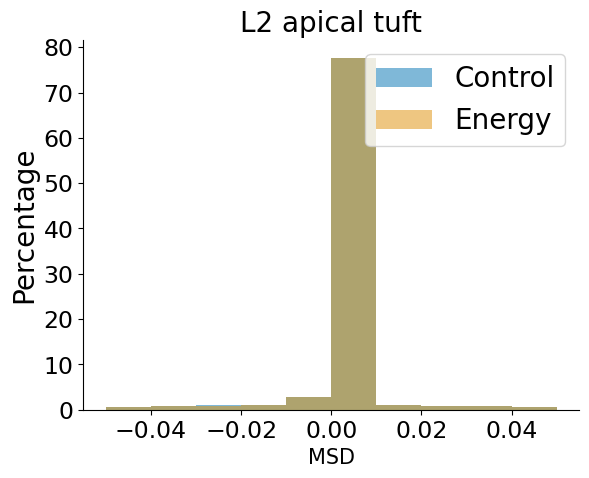

In [38]:
keep_time=True # value of each neuron is averaged over all timepoints
element='apical'
clamp_value = 1
l2_diff_control_surprise,l2_diff_control_expected  = get_results(control_model,element,keep_time,seed,clamp_value)
l2_diff_energy_surprise,l2_diff_energy_expected = get_results(energy_model,element,keep_time,seed,clamp_value)

l2_diff_control = np.mean(l2_diff_control_expected-l2_diff_control_surprise,axis=1)
l2_diff_energy = np.mean(l2_diff_energy_expected-l2_diff_energy_surprise,axis=1)

np.save('graphs_intermediate_results\\surprise_voltage_diff_control_apical_L2_retry.npy',l2_diff_control)
np.save('graphs_intermediate_results\\surprise_voltage_diff_energy_apical_L2_retry.npy',l2_diff_energy)

plot_voltage_diff_only_L2(l2_diff_control,l2_diff_energy,'apical tuft')

# 5d

In [ ]:
keep_time=True
element='soma'
l2_diff_control_surprise,l2_diff_control_expected  = get_results(control_model,element,keep_time,seed,clamp_value)
l2_diff_energy_surprise,l2_diff_energy_expected = get_results(energy_model,element,keep_time,seed,clamp_value)

l2_diff_control = np.mean(l2_diff_control_expected-l2_diff_control_surprise,axis=1)
l2_diff_energy = np.mean(l2_diff_energy_expected-l2_diff_energy_surprise,axis=1)

np.save('graphs_intermediate_results\\surprise_voltage_diff_control_soma_L2_with_feedback.npy',l2_diff_control)
np.save('graphs_intermediate_results\\surprise_voltage_diff_energy_soma_L2_with_feedback.npy',l2_diff_energy)

plot_voltage_diff_only_L2(l2_diff_control,l2_diff_energy,'soma')

# 5e

In [ ]:
keep_time=True
element='spikes'
l1_diff_control_surprise,l1_diff_control_expected, l2_diff_control_surprise,l2_diff_control_expected, l3_diff_control_surprise,l3_diff_control_expected = get_results(control_model,element,keep_time,seed,clamp_value)
l1_diff_energy_surprise,l1_diff_energy_expected, l2_diff_energy_surprise,l2_diff_energy_expected, l3_diff_energy_surprise,l3_diff_energy_expected = get_results(energy_model,element,keep_time,seed,clamp_value)

l1_diff_control = np.mean(l1_diff_control_expected-l1_diff_control_surprise,axis=1)
l1_diff_energy = np.mean(l1_diff_energy_expected-l1_diff_energy_surprise,axis=1)
l2_diff_control = np.mean(l2_diff_control_expected-l2_diff_control_surprise,axis=1)
l2_diff_energy = np.mean(l2_diff_energy_expected-l2_diff_energy_surprise,axis=1)
l3_diff_control = np.mean(l3_diff_control_expected-l3_diff_control_surprise,axis=1)
l3_diff_energy = np.mean(l3_diff_energy_expected-l3_diff_energy_surprise,axis=1)

np.save('graphs_intermediate_results\\surprise_voltage_diff_control_spikes_L1_with_feedback.npy',l1_diff_control)
np.save('graphs_intermediate_results\\surprise_voltage_diff_energy_spikes_L1_with_feedback.npy',l1_diff_energy)
np.save('graphs_intermediate_results\\surprise_voltage_diff_control_spikes_L2_with_feedback.npy',l2_diff_control)
np.save('graphs_intermediate_results\\surprise_voltage_diff_energy_spikes_L2_with_feedback.npy',l2_diff_energy)
np.save('graphs_intermediate_results\\surprise_voltage_diff_control_spikes_L3_with_feedback.npy',l3_diff_control)
np.save('graphs_intermediate_results\\surprise_voltage_diff_energy_spikes_L3_with_feedback.npy',l3_diff_energy)

plot_voltage_diff_only_L2(l2_diff_control,l2_diff_energy,"$\delta$$R$")

# 5f

In [ ]:
keep_time=True
element='spikes'

fig,ax=plt.subplots(1,1)
X_axis = np.arange(3)

palette = sns.color_palette("colorblind")
pastel_blue = palette[0]
pastel_orange = palette[1]

ax.bar(X_axis-0.2,[np.abs(l1_diff_control).mean(), np.abs(l2_diff_control).mean(), np.abs(l3_diff_control).mean()],0.4,color=pastel_blue,label="Control")
ax.bar(X_axis+0.2,[np.abs(l1_diff_energy).mean(), np.abs(l2_diff_energy).mean(), np.abs(l3_diff_energy).mean()],0.4,color=pastel_orange,label="Energy")

ax.spines[['right', 'top']].set_visible(False)

labels=["1","2","3"]
plt.xticks(X_axis, labels, fontsize=20) 
plt.yticks(fontsize=20)
plt.xlabel("Layer",fontsize=20) 
plt.ylabel(r"$\delta$$R$",fontsize=20) 
plt.title(r"$\delta$$R$ match vs. mismatch",fontsize=20) 
plt.legend(fontsize=20) 
plt.savefig('graphs_intermediate_results\\surprise_voltage_diff_{}_average_with_feedback.png'.format('spikes'),bbox_inches='tight')
plt.show() 